In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def generate_data(n,d,k,sigma_eps,mu_eps):
    X = np.random.randn(n,d) # X ~ N(0,I)
    
    wtrue = np.zeros(d)
    for j in range(k):
        wtrue[j] = (j+1)/k
        
    eps = sigma_eps*np.random.randn(n) + mu_eps  # eps ~ N(sigma_eps^2,mu_eps)
    y = X.dot(wtrue) + eps    
    
    return X,y,wtrue


def lambda_max(X,y):
    #X has d-rows of features and n-columns of data
    n = X.shape[0]
    lammax = np.max(2*np.abs(X.T.dot(y - (1/n)*np.sum(y))))
    return lammax


In [3]:
# create synthetic data as specified in problem 3

# parameters
n = 500
d = 1000
k = 100
sigma = 1

# for reproducibility
np.random.seed(0) 
X,y,wtrue = generate_data(n,d,k,sigma,0)

# lambda max
lammax = lambda_max(X,y)

In [4]:
def lasso_algo(X,y,tolerance,lam):
    n = X.shape[0]
    d = X.shape[1]
    
    # initialize
    a = np.zeros(d)
    c = np.zeros(d)
    w = np.zeros(d)
    wold = np.zeros(d)
    
    # lasso loop
    tolerance_check = True
    while tolerance_check:
        wold[:] = w
        b = (1/n)*np.sum(y - X.dot(w))  
        for j in range(d):
            a[j] = 2*np.sum(X[:,j]**2)
            c[j] = np.sum(X[:,j]*(y - (b + X.dot(w) - X[:,j]*w[j])))
            if c[j] > lam:
                w[j] = (c[j] - lam)/a[j]
            elif c[j] < -lam:
                w[j] = (c[j] + lam)/a[j]
            else:
                w[j] = 0
        tolerance_check = (abs(wold - w) >= tolerance).all()
    return w


def postprocessing(w,wtrue):
    # feature information
    discovered_features = np.count_nonzero(w)
    nz_idx_wtrue = wtrue.nonzero() #nonzero indices in wtrue            
    nz_idx_w = w.nonzero() #nonzero indices in w
    correct_features = len(np.intersect1d(nz_idx_wtrue[0],nz_idx_w[0]))
    incorrect_features = discovered_features - correct_features
    if discovered_features == 0:
        FDR = 0
    else:
        FDR = incorrect_features / discovered_features 
    TPR = correct_features / len(nz_idx_wtrue[0])
    
    return FDR, TPR, discovered_features, correct_features, incorrect_features

<IPython.core.display.Javascript object>


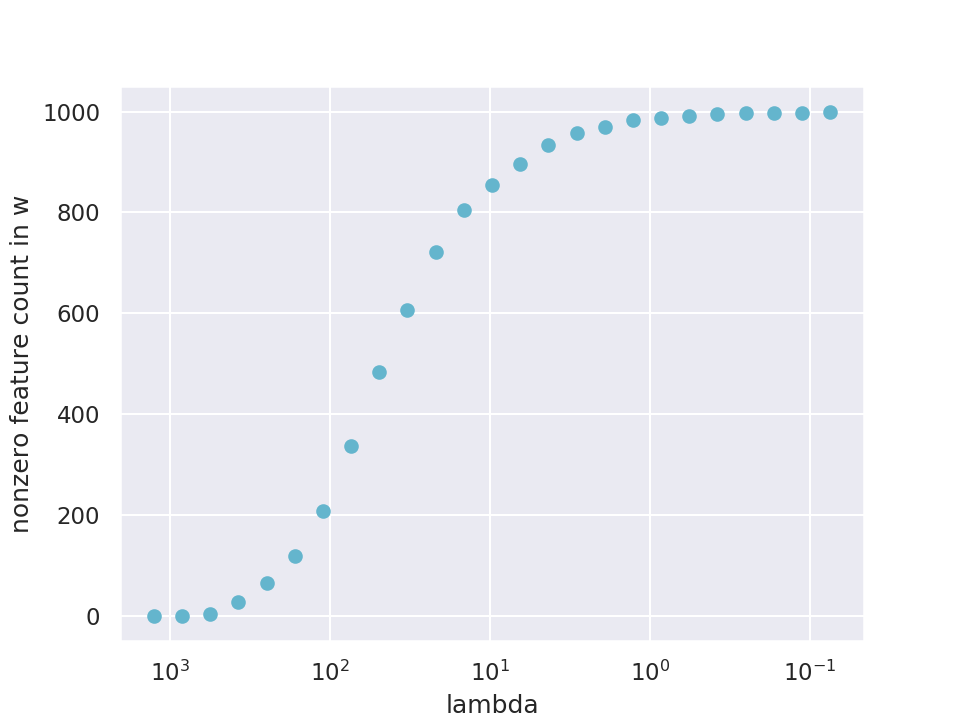

<IPython.core.display.Javascript object>


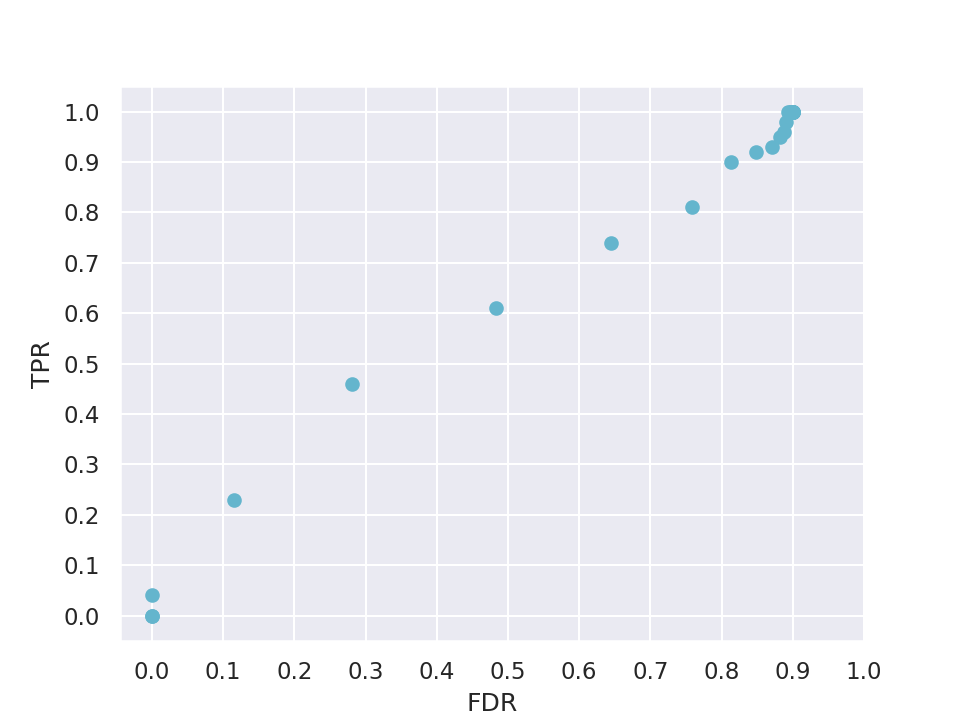

CPU times: user 16.5 s, sys: 205 ms, total: 16.7 s
Wall time: 4.25 s


In [7]:
%%time
# LASSO

tolerance = 1e-3
lam = lammax
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()

# Solve LASSO along regularization path
lambda_trials = 25
for i in range(lambda_trials):
    # LASSO algorithm
    w = lasso_algo(X,y,tolerance,lam)
      
    # process and plot data
    FDR, TPR, discovered_features, correct_features, incorrect_features = postprocessing(w,wtrue)
    ax.plot(lam,discovered_features,'o',color='c')
    ax2.plot(FDR,TPR,'o',color='c')
    
    # reduce lambda for next trial
    lam = lam/1.5 

ax.set(xlabel='lambda',ylabel='nonzero feature count in w', xscale='log')
fig.gca().invert_xaxis()
ax2.set(xlabel='FDR',ylabel='TPR',xticks=np.arange(0,1.1,0.1),yticks=np.arange(0,1.1,0.1))